# Toy data wine classification

In [18]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
from sklearn.datasets import load_wine
import matplotlib.pyplot as plt
from matplotlib import colors 
import colour

%config InlineBackend.figure_format = 'retina'

import tsensor

dtype = torch.double

## Load and normalize and display 2D variable space

In [2]:
d = load_wine()
sum(d.target==2)

48

In [3]:
df = pd.DataFrame(d.data, columns=d.feature_names)
df['class'] = d.target
df = df[df['class'].isin({0,1})]
df.head(3)

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline,class
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0,0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0,0
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0,0


In [4]:
df = df[['proline','alcohol','class']]
df.head(3)

,proline,alcohol,class
0,1065.0,14.23,0
1,1050.0,13.20,0
2,1185.0,13.16,0


In [33]:
def show(df, normalize=False, file=None):
    if normalize:
        df = df.copy()
        df.proline = (df.proline-np.mean(df.proline))/np.std(df.proline)
        df.alcohol = (df.alcohol-np.mean(df.alcohol))/np.std(df.alcohol)
        
    fig, ax = plt.subplots(figsize=(4,3))
    df0 = df[df['class']==0]
    df1 = df[df['class']==1]
    ax.scatter(df0.proline, df0.alcohol, marker='x', s=45, color='#F46C43', alpha=1, label='class 0')
    ax.scatter(df1.proline, df1.alcohol, marker='o', s=45, color='#4574B4', alpha=.7, label='class 1')
    ax.set_xlabel("proline")
    ax.set_ylabel("alcohol")
    ax.set_title("Wine classification")
    plt.legend(loc='lower right')
    plt.tight_layout()
    if file:
        plt.savefig(f"/Users/parrt/Desktop/{file}.pdf")
    plt.show()

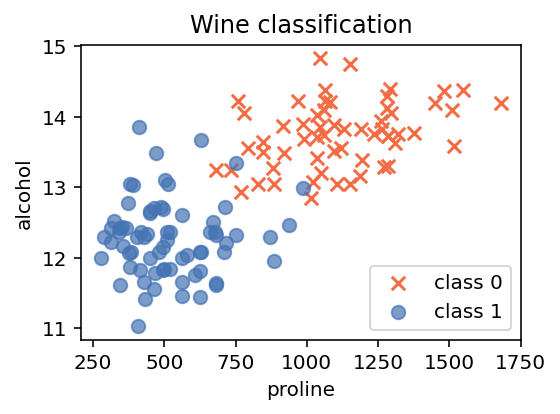

In [34]:
show(df, file="wine")

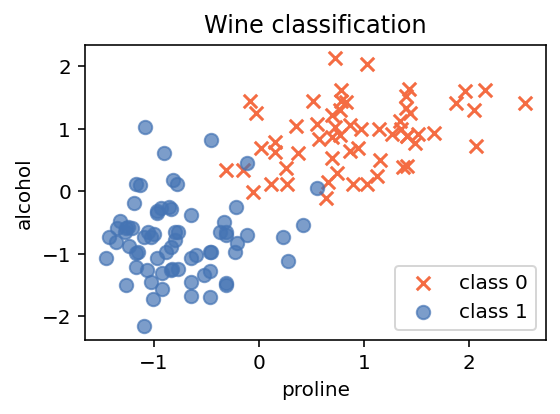

In [35]:
show(df, normalize=True, file="wine-norm")

## Train and show logistic regression decision boundary

In [19]:
def ctrain(model, X, y, learning_rate = .0001, nepochs=2000):
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    for epoch in range(nepochs+1):
        y_pred = model(X)
        loss = F.binary_cross_entropy(y_pred, y)
        if epoch % (nepochs//10) == 0:
            print(f"Epoch {epoch:5d} cross entropy loss {loss:7.4f}")

        optimizer.zero_grad()
        loss.backward() # autograd computes w1.grad, b1.grad, ...
        optimizer.step()
    print(f"LAST        cross entropy loss {loss:7.4f}")
    return y_pred, loss

In [31]:
def dshow(X, y, model, boundary_tolerance=.03, file=None):
    grid = []
    for p in np.linspace(min(X[:,0]),max(X[:,0]),num=100):
        for a in np.linspace(min(X[:,1]),max(X[:,1]),num=100):
            grid.append([p,a])
    grid = torch.tensor(grid).float()
    decisions = model(grid).detach().numpy().reshape(-1)
    
    grid_boundary = grid[np.isclose(decisions,0.5,atol=boundary_tolerance),:]
    
    fig, ax = plt.subplots(figsize=(5,4))
    X0 = X[y==0]
    X1 = X[y==1]

    orange = colour.Color("#F46C43")
    blue = colour.Color("#4574B4")
    mycolors = np.array(list(c.hex for c in orange.range_to(blue, 100+1)))
    mycolors = mycolors[(decisions*100).astype(int)]
    cmap = plt.get_cmap('coolwarm')
    norm = colors.Normalize(np.min(decisions), np.max(decisions)) # cmap(norm(decisions))
    ax.scatter(grid[:,0], grid[:,1], s=.2, c=mycolors, alpha=.3)

    ax.scatter(grid_boundary[:,0], grid_boundary[:,1], s=1, c='k', alpha=1)

    ax.scatter(X0[:,0], X0[:,1], marker='x', s=45, lw=.9, color='#F46C43', alpha=1, label='class 0')
    ax.scatter(X1[:,0], X1[:,1], marker='o', s=45, lw=.9, color='#4574B4', alpha=.75, label='class 1')    

    ax.set_xlabel("proline")
    ax.set_ylabel("alcohol")
    ax.set_title("Wine classification")
    plt.legend(loc='lower right')
    plt.tight_layout()

    if file:
        plt.savefig(f"/Users/parrt/Desktop/{file}.pdf")
    
    plt.show()

Epoch     0 cross entropy loss  0.5542
Epoch  1500 cross entropy loss  0.1713
Epoch  3000 cross entropy loss  0.1141
Epoch  4500 cross entropy loss  0.0927
Epoch  6000 cross entropy loss  0.0828
Epoch  7500 cross entropy loss  0.0781
Epoch  9000 cross entropy loss  0.0763
Epoch 10500 cross entropy loss  0.0759
Epoch 12000 cross entropy loss  0.0758
Epoch 13500 cross entropy loss  0.0758
Epoch 15000 cross entropy loss  0.0758
LAST        cross entropy loss  0.0758


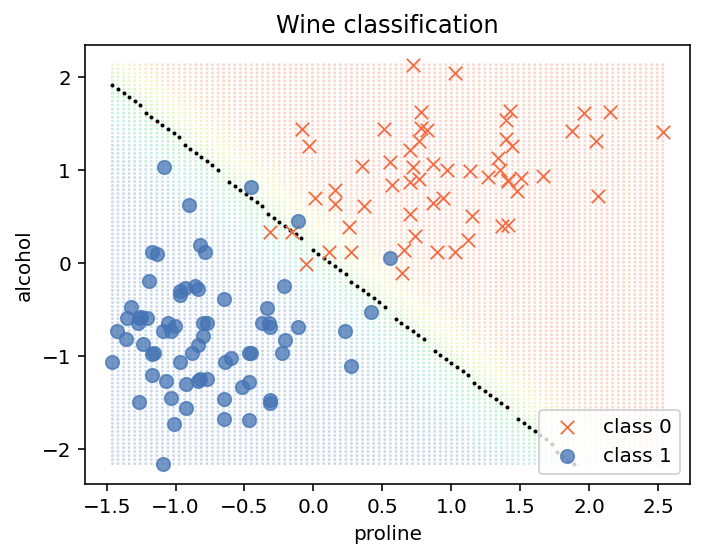

In [36]:
model = nn.Sequential(
    nn.Linear(2, 1), # 2 input vars: proline, alcohol
    nn.Sigmoid(),
)
X = df[['proline','alcohol']].values
y = df['class'].values
X = (X-np.mean(X,axis=0))/np.std(X,axis=0)
X_ = torch.tensor(X).float()
y_ = torch.tensor(y).reshape(-1,1).float()
y_pred, loss = ctrain(model, X=X_, y=y_, learning_rate = .001, nepochs=15_000)

dshow(X, y, model, boundary_tolerance=.02, file="lin1S")

## Train input layer with 3 neurons + output layer

Epoch     0 cross entropy loss  0.7035
Epoch  1500 cross entropy loss  0.1784
Epoch  3000 cross entropy loss  0.1014
Epoch  4500 cross entropy loss  0.0856
Epoch  6000 cross entropy loss  0.0800
Epoch  7500 cross entropy loss  0.0707
Epoch  9000 cross entropy loss  0.0590
Epoch 10500 cross entropy loss  0.0522
Epoch 12000 cross entropy loss  0.0474
Epoch 13500 cross entropy loss  0.0441
Epoch 15000 cross entropy loss  0.0420
LAST        cross entropy loss  0.0420


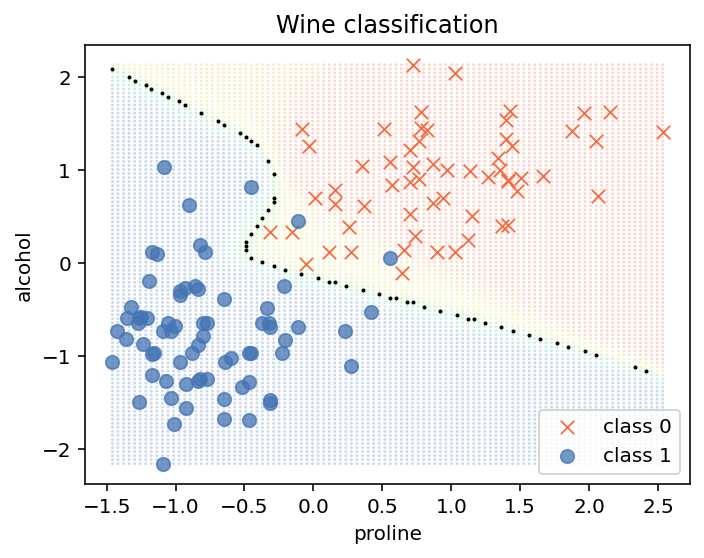

In [40]:
model = nn.Sequential(
    nn.Linear(2, 3),
    nn.Sigmoid(),
    nn.Linear(3, 1),
    nn.Sigmoid()
)
X = df[['proline','alcohol']].values
y = df['class'].values
X = (X-np.mean(X,axis=0))/np.std(X,axis=0)
X_ = torch.tensor(X).float()
y_ = torch.tensor(y).reshape(-1,1).float()
y_pred, loss = ctrain(model, X=X_, y=y_, learning_rate = .001, nepochs=15_000)

dshow(X, y, model, file="lin3Slin1S")

## Train input layer with 10 neurons + output layer

Epoch     0 cross entropy loss  0.7672
Epoch  1500 cross entropy loss  0.0796
Epoch  3000 cross entropy loss  0.0763
Epoch  4500 cross entropy loss  0.0665
Epoch  6000 cross entropy loss  0.0539
Epoch  7500 cross entropy loss  0.0488
Epoch  9000 cross entropy loss  0.0414
Epoch 10500 cross entropy loss  0.0241
Epoch 12000 cross entropy loss  0.0130
Epoch 13500 cross entropy loss  0.0065
Epoch 15000 cross entropy loss  0.0032
LAST        cross entropy loss  0.0032


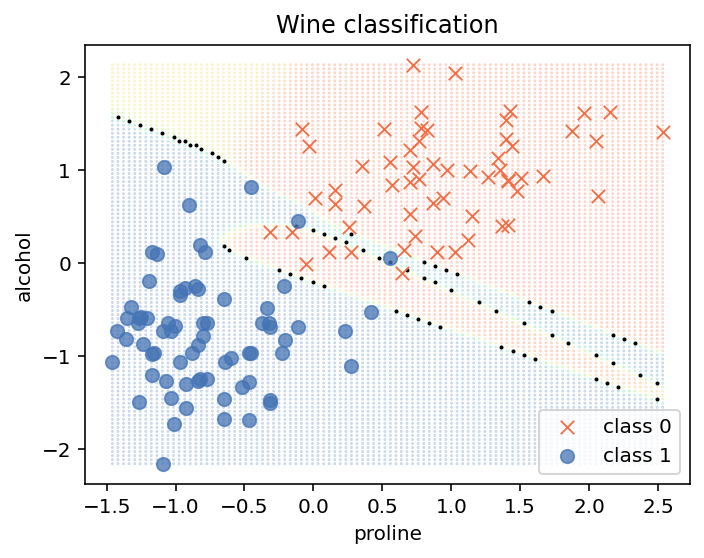

In [45]:
model = nn.Sequential(
    nn.Linear(2, 10), # 2 input vars: proline, alcohol
    nn.Sigmoid(),
    nn.Linear(10, 1),
    nn.Sigmoid()
)
X = df[['proline','alcohol']].values
y = df['class'].values
X = (X-np.mean(X,axis=0))/np.std(X,axis=0)
X_ = torch.tensor(X).float()
y_ = torch.tensor(y).reshape(-1,1).float()
y_pred, loss = ctrain(model, X=X_, y=y_, learning_rate = .002, nepochs=15_000)

dshow(X, y, model, boundary_tolerance=.07, file="lin10Tlin")

## Train one-hidden layer with 10 neurons

Epoch     0 cross entropy loss  0.7447
Epoch  1500 cross entropy loss  0.0534
Epoch  3000 cross entropy loss  0.0408
Epoch  4500 cross entropy loss  0.0231
Epoch  6000 cross entropy loss  0.0195
Epoch  7500 cross entropy loss  0.0008
Epoch  9000 cross entropy loss  0.0002
Epoch 10500 cross entropy loss  0.0001
Epoch 12000 cross entropy loss  0.0000
Epoch 13500 cross entropy loss  0.0000
Epoch 15000 cross entropy loss  0.0000
LAST        cross entropy loss  0.0000


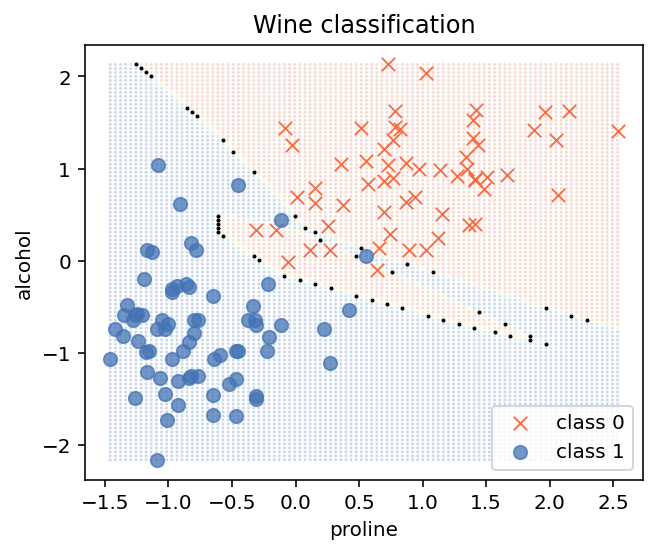

In [16]:
model = nn.Sequential(
    nn.Linear(2, 10), # 2 input vars: proline, alcohol
    nn.ReLU(),
    nn.Linear(10, 10),
    nn.ReLU(),
    nn.Linear(10, 1),
    nn.Sigmoid()
)
X = df[['proline','alcohol']].values
y = df['class'].values
X = (X-np.mean(X,axis=0))/np.std(X,axis=0)
X_ = torch.tensor(X).float()
y_ = torch.tensor(y).reshape(-1,1).float()
y_pred, loss = ctrain(model, X=X_, y=y_, learning_rate = .001, nepochs=15_000)

dshow(X, y, model, boundary_tolerance=.1)